# Single asset strategy test



In [1]:

import sys, os
from pathlib import Path
import pandas as pd
import pprint as _pp
PROJECT_ROOT = Path("..").resolve()
SRC_DIR = PROJECT_ROOT / "src"
if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))


DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(parents=True, exist_ok=True)


from hedge.data import (
    DataScheme,
    load_ohlcv_by_code,
    download_binance_ohlcv_csv,
    ensure_ohlcv_dataset,   
)
from hedge.fitting.losses import Objective           # loss spec dataclass
from hedge.fitting.learning import LearningConfig, OptimizationConfig, _mk_learning, _mk_optimization  # train configs

from hedge.run import train_on_csv, run_on_csv
from hedge.strategies import SingleAssetMACrossover
from hedge.portfolio import CASH_COL
from hedge import viz


import pandas as pd
import numpy as np


In [2]:
# --- USER PARAMETERS ---
SYMBOL      = "BTCUSDT"     
INTERVAL    = "1h"         
START       = "2022-01-01"  
END         = None          
TRAIN_END   = "2022-12-01"  


STRAT_NAME = "single-asset-ma-crossover"
STRAT_PARAMS = dict(
    asset=SYMBOL,
    price_field="close",
    fast_window=20,
    slow_window=50,
    w_long=1.0,
    w_short=0.0,      
    clip_per_asset=1.0,
    warmup_bars=50,   
    trade_lag_bars=1,
    rebalance_every=None,
)



/Users/vladimir.dmitriev/Desktop/ai-hedge-fund/src/hedge/data.py:536: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  cat.loc[mask, :] = rep.values


1 /Users/vladimir.dmitriev/Desktop/ai-hedge-fund/data/1.csv
                               open      high       low     close      volume
timestamp                                                                    
2022-01-01 00:59:59+00:00  46216.93  46731.39  46208.37  46656.13  1503.33095
2022-01-01 01:59:59+00:00  46656.14  46949.99  46574.06  46778.14   943.81539
2022-01-01 02:59:59+00:00  46778.14  46928.94  46721.96  46811.77   485.16860
                                open       high        low      close  \
timestamp                                                               
2025-09-25 18:59:59+00:00  108833.63  109801.78  108631.51  109760.20   
2025-09-25 19:59:59+00:00  109760.20  109973.40  109302.54  109360.00   
2025-09-25 20:59:59+00:00  109360.00  109482.62  109081.15  109163.44   

                               volume  
timestamp                              
2025-09-25 18:59:59+00:00  1427.42291  
2025-09-25 19:59:59+00:00  1217.19366  
2025-09-25 20:59:59+00:0

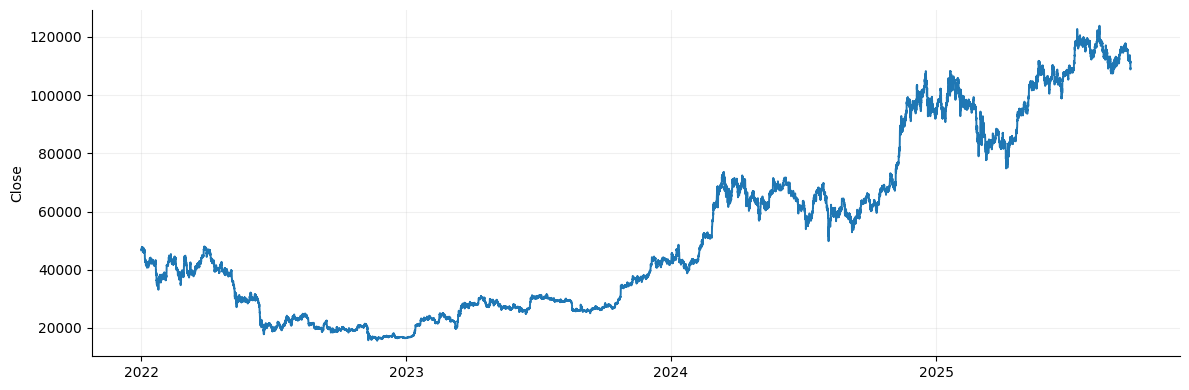

In [3]:

code, path = ensure_ohlcv_dataset(SYMBOL, INTERVAL, START, END, data_dir=DATA_DIR, overwrite=True)

print(code, path)
# Load & validate
df = load_ohlcv_by_code(code, data_dir=DATA_DIR)
print(df.head(3))
print(df.tail(3))
print("Rows:", len(df), "| Index tz:", df.index.tz)

if viz.plot_price_or_candles:
    viz.plot_price_or_candles(df, asset=SYMBOL, mode="candles") 
else:
    ax = df["close"].plot(title=f"{SYMBOL} {INTERVAL} close")
    ax.set_xlabel("time"); ax.set_ylabel("price")


In [4]:


def split_train_test(df: pd.DataFrame, train_end: str | pd.Timestamp) -> tuple[pd.DataFrame, pd.DataFrame]:
    ts = pd.Timestamp(train_end)
    if ts.tz is None:
        ts = ts.tz_localize("UTC")
    else:
        ts = ts.tz_convert("UTC")
    train = df.loc[df.index <= ts].copy()
    test  = df.loc[df.index >  ts].copy()
    if len(train) == 0 or len(test) == 0:
        raise ValueError("Split produced an empty train or test set; adjust TRAIN_END.")
    return train, test

def save_ohlcv_csv(dfx: pd.DataFrame, path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    tmp = dfx.reset_index()
    # ensure the datetime column is named 'timestamp'
    if "timestamp" not in tmp.columns:
        # the reset_index will name it whatever the index name was; normalize it
        ts_col = tmp.columns[0]
        tmp = tmp.rename(columns={ts_col: "timestamp"})
    tmp["timestamp"] = pd.to_datetime(tmp["timestamp"], utc=True).dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    tmp[["timestamp", "open", "high", "low", "close", "volume"]].to_csv(path, index=False)

# --- split ---
train_df, test_df = split_train_test(df, TRAIN_END)

# --- paths ---
TRAIN_DIR = DATA_DIR / f"training_{code}"
TRAIN_CSV = TRAIN_DIR / "train.csv"
TEST_CSV  = TRAIN_DIR / "test.csv"

# --- save ---
save_ohlcv_csv(train_df, TRAIN_CSV)
save_ohlcv_csv(test_df,  TEST_CSV)

print(f"[ok] Train CSV: {TRAIN_CSV} | rows={len(train_df)}")
print(f"[ok] Test  CSV: {TEST_CSV}  | rows={len(test_df)}")


[ok] Train CSV: /Users/vladimir.dmitriev/Desktop/ai-hedge-fund/data/training_1/train.csv | rows=8016
[ok] Test  CSV: /Users/vladimir.dmitriev/Desktop/ai-hedge-fund/data/training_1/test.csv  | rows=24716


[learning] applying keys: ['cost_config', 'objective']
[optimization] applying keys: ['mode', 'random_state']

— Training setup —
strategy: single-asset-ma-crossover
params :
{'asset': 'BTCUSDT',
 'fast_window': 20,
 'price_field': 'close',
 'rebalance_every': None,
 'slow_window': 50,
 'trade_lag_bars': 1,
 'w_long': 1.0,
 'w_short': 0.0}
objective: Objective(name='neg_log_wealth', annualizer=365.0, rf_per_period=0.0, init_equity=1.0, eps=1e-12, tau=10.0, smooth_max_tau=None, weight_turnover=0.0, weight_leverage=0.0)
costs    :
{'leverage_funding': {'funding_bps': 0.0},
 'short_borrow': {'borrow_bps': 5.0},
 'turnover': {'apply_half': True, 'fee_bps': 1.0, 'slippage_bps': 2.0}}
train csv: /Users/vladimir.dmitriev/Desktop/ai-hedge-fund/data/training_1/train.csv

[ok] trained.
best loss   : 0.3656897164941004
best params :
{}
model saved : models/single-asset-ma-crossover_1_20250925_204933.json

— Test metrics —
{'cagr_years': 0.32974053069513065,
 'calmar_nominal': 0.8763595887518881,


/Users/vladimir.dmitriev/Desktop/ai-hedge-fund/src/hedge/viz.py:278: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


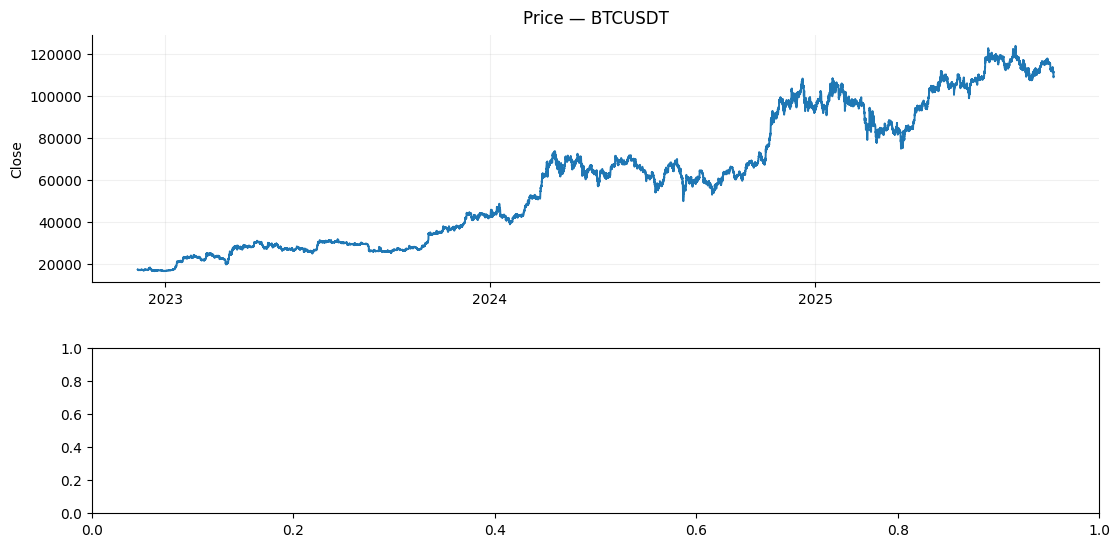

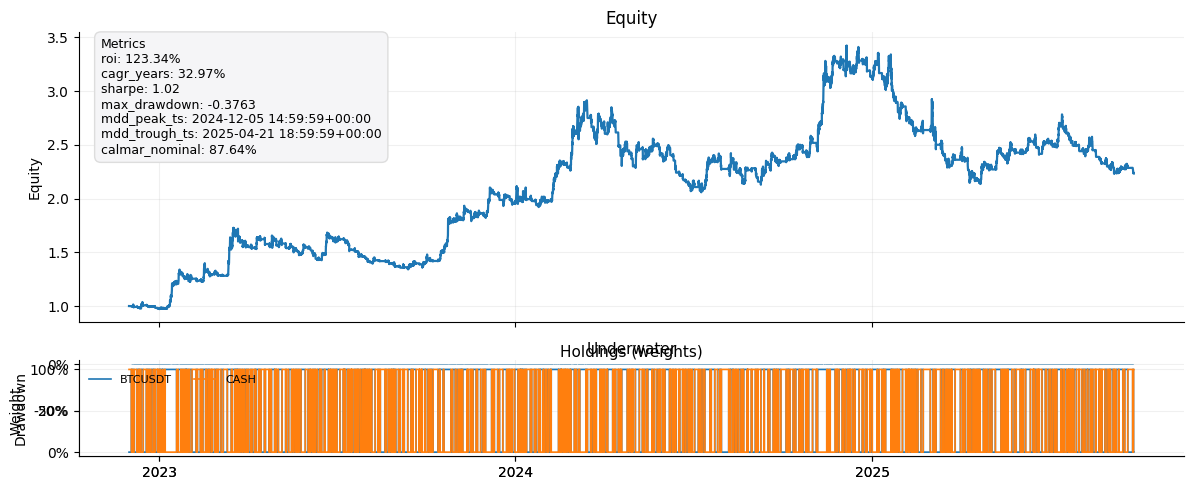

In [5]:
# =========================
# Training config + run
# =========================

# These are passed to SingleAssetMACrossover (see strategies.py).
strategy_name = "single-asset-ma-crossover"
strategy_params = dict(
    asset=SYMBOL,       
    price_field="close",
    fast_window=20,
    slow_window=50,
    w_long=1.0,         
    w_short=0.0,        
    trade_lag_bars=1,   
    rebalance_every=None,
)

# ------------------------------------------------
# Cost models (rates subtracted from returns)
# ------------------------------------------------
# Registry keys come from hedge/fitting/cost_models.py:
#   "turnover", "power_turnover", "short_borrow", "leverage_funding", "per_asset_funding"

cost_config = {
    # linear turnover in bps; apply_half=True for ½·Σ|Δw| convention
    "turnover": {"fee_bps": 1.0, "slippage_bps": 2.0, "apply_half": True},
    # borrow fee on short exposure only (bps). No effect if you don't short.
    "short_borrow": {"borrow_bps": 5.0},
    # funding on excess gross exposure beyond 1.0 (bps). 0 disables.
    "leverage_funding": {"funding_bps": 0.0},
    # Example (disabled): per-asset funding schedule
    # "per_asset_funding": {"funding_rates": np.zeros((T, M))},
}

# -----------------------------------------
# 3) Objective
# -----------------------------------------
# Options (see losses.Objective):
#   - name="neg_log_wealth"          (robust, default)
#   - name="neg_sharpe"              (needs annualizer, uses rf_per_period)
#   - name="drawdown"                (uses init_equity, tau, smooth_max_tau)
objective = Objective(
    name="neg_log_wealth",
    eps=1e-12,
    # for neg_sharpe you'd want: annualizer=365.0 (1D) or 24*365 for 1H, rf_per_period=0.0
)

# -----------------------------------------------------------
# 4) Learning & Optimization 
# -----------------------------------------------------------


# Typical knobs (only those present in your dataclasses will be applied):
learning_cfg = _mk_learning(
    objective=objective,
    cost_config=cost_config,   # sent through to evaluate_objective
    rf=0.0,                    # per-period cash return if your pipeline uses it
    # bars_per_unit=365.0,     # if your LearningConfig supports it for Sharpe
)

optimization_cfg = _mk_optimization(
    mode="random",             # e.g. "random" | "grid" | "gradient" (depends on your impl)
    n_trials=80,               # random/grid search trials
    max_iters=0,               # for gradient modes (if supported); 0 disables
    random_state=42,
    # device="cpu",            # only if your OptimizationConfig supports torch device routing
)

print("\n— Training setup —")
print("strategy:", strategy_name)
print("params :"); _pp.pprint(strategy_params)
print("objective:", objective)
print("costs    :"); _pp.pprint(cost_config)
print("train csv:", TRAIN_CSV)

# ----------------
# 5) Train
# ----------------
train_res = train_on_csv(
    csv_path=TRAIN_CSV,
    strategy_name=strategy_name,
    strategy_params=strategy_params,
    learning=learning_cfg,
    optimization=optimization_cfg,
    model_dir="models",
    code_hint=str(code),   # use dataset numeric code in the saved filename
)

print("\n[ok] trained.")
print("best loss   :", getattr(train_res.fit, "best_loss", None))
print("best params :"); _pp.pprint(getattr(train_res.fit, "best_params", None))
print("model saved :", train_res.model_path)

# ----------------
# 6) Test / inference
# ----------------
run_res = run_on_csv(
    csv_path=TEST_CSV,
    strategy_or_model=train_res.model_path,  # load the saved model for inference
)



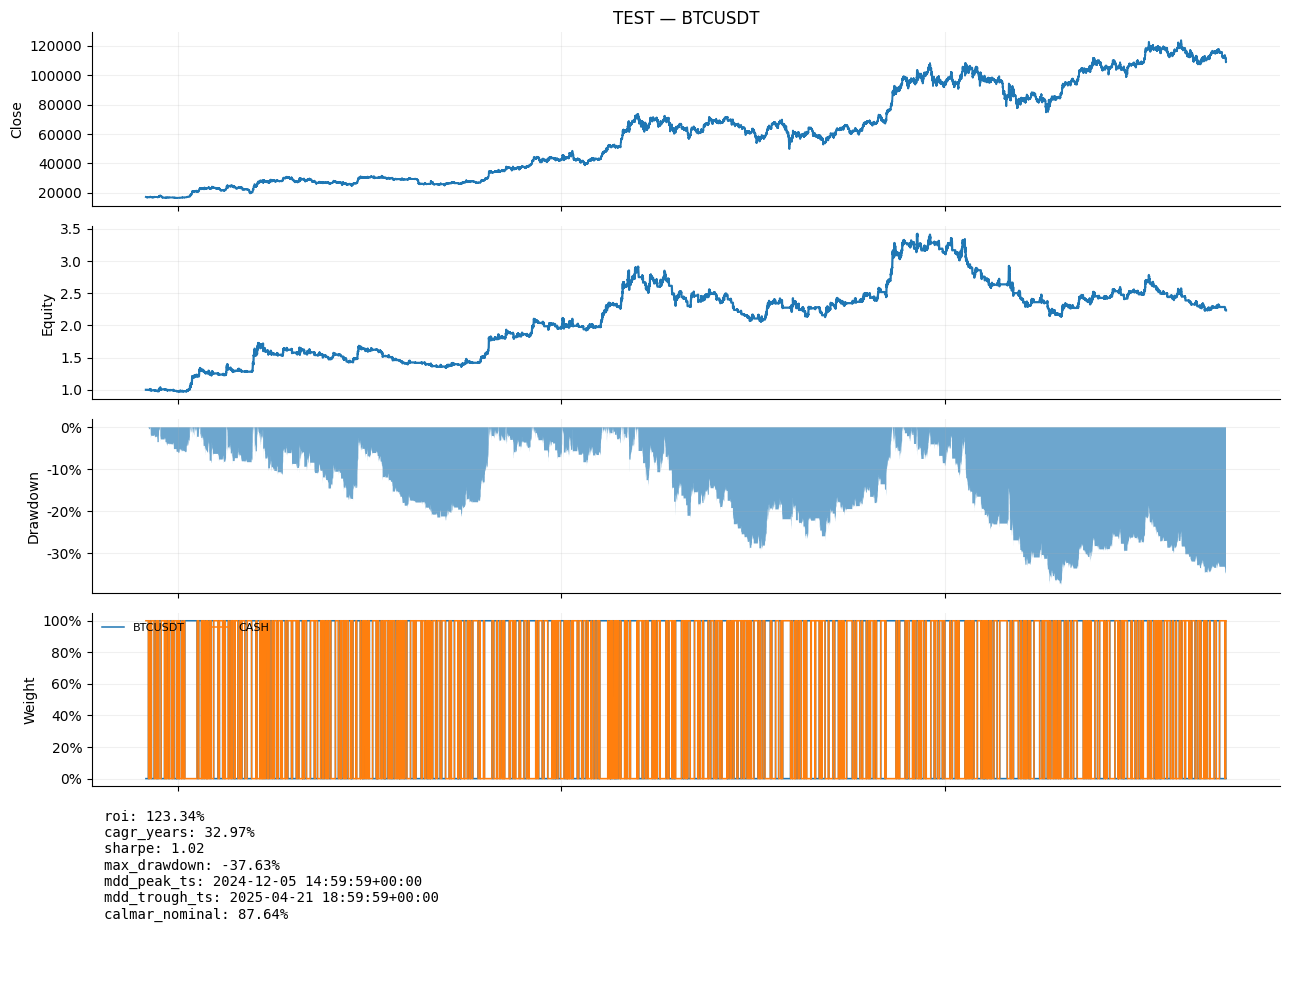

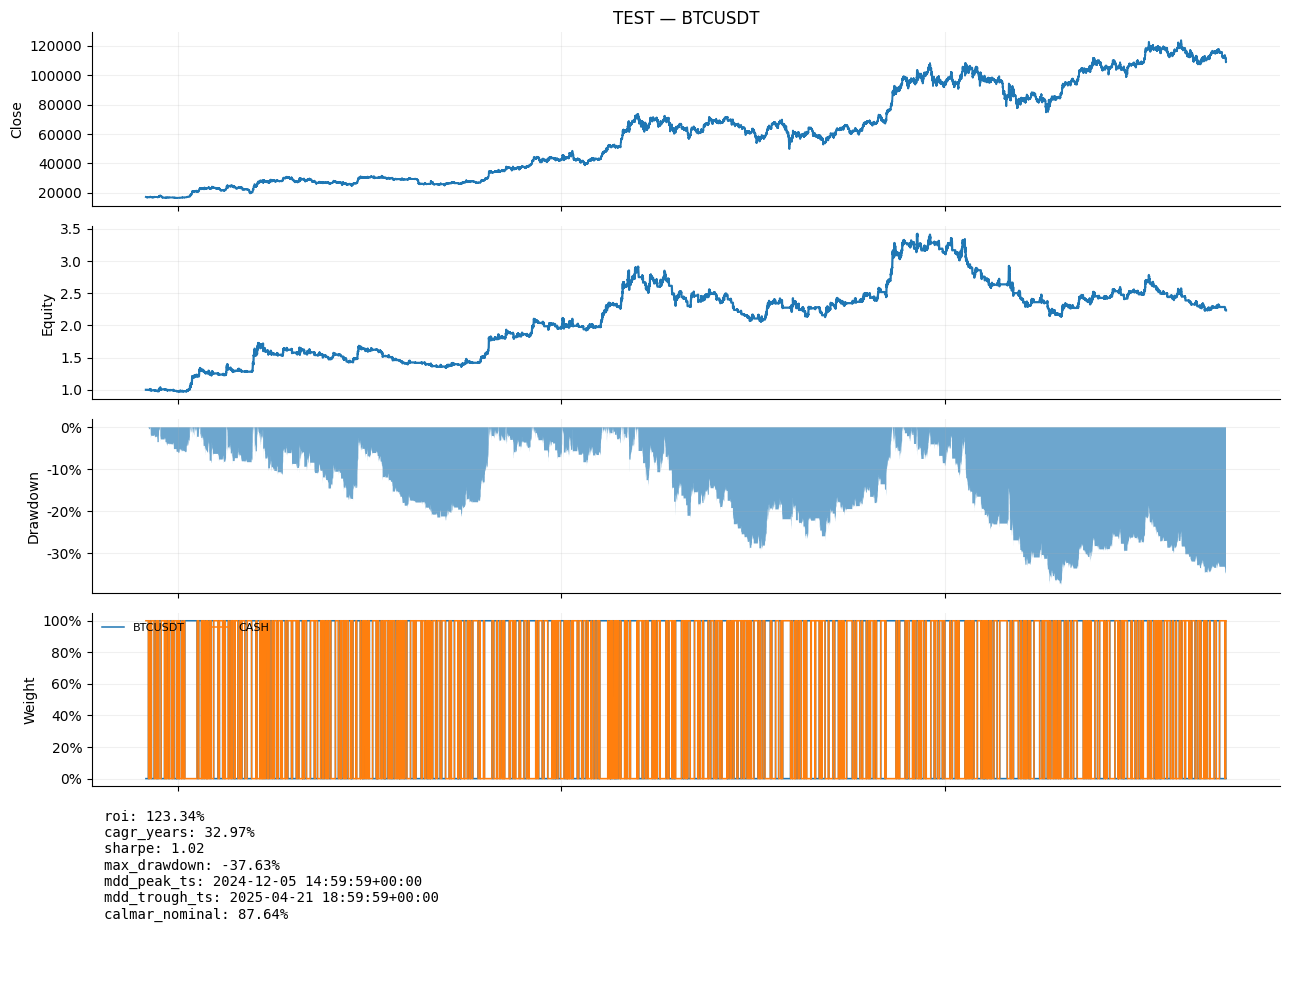

In [8]:

viz.plot_run_simple(
    df=test_df,
    weights=run_res.weights,
    equity=run_res.equity,
    metrics=run_res.metrics,
    asset=SYMBOL,
    title=f"TEST — {SYMBOL}",
    show=True,
)